In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score
from openai import OpenAI
import configparser
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

In [2]:
# Downloading necessary data
data_x = pd.read_csv('data/interview.X.csv')
data_y = pd.read_csv('data/interview.y.csv')

### Investiagating x data

In [3]:
# Remove duplicates
data_x = data_x.drop_duplicates()

In [4]:
# Information about data
data_x.info()

<class 'pandas.core.frame.DataFrame'>
Index: 955215 entries, 0 to 955238
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   reg_time     955215 non-null  object
 1   uid          955215 non-null  object
 2   fc_imp_chk   955215 non-null  int64 
 3   fc_time_chk  955215 non-null  int64 
 4   utmtr        955215 non-null  int64 
 5   mm_dma       955215 non-null  int64 
 6   osName       947323 non-null  object
 7   model        946820 non-null  object
 8   hardware     947030 non-null  object
 9   site_id      955215 non-null  object
dtypes: int64(4), object(6)
memory usage: 80.2+ MB


As we see, there are some missing data in last 4 columns. If features are relevant, we need to somehow handle it

In [5]:
data_x['osName'].unique()

array(['iOS', 'Android', nan, 'Windows 10', 'Windows 8.1', 'Windows 7',
       'Symbian', 'Linux', 'Windows XP', 'Tizen', 'KaiOS', 'OS X'],
      dtype=object)

In [6]:
# Replacing Nan in os name with "unnown"
data_x['osName'].fillna('Unknown os', inplace=True)

In [7]:
data_x['model'].unique()

array(['iPhone XR', 'iPhone', 'SM-G998U', ..., 'XQ-AU52', 'SM-A013M',
       'M20'], dtype=object)

In [8]:
# The same with model
data_x['model'].fillna('Unknow model', inplace=True)

In [9]:
# Also for hardwere and site
data_x['hardware'].fillna('Unknown hardwere', inplace=True)
data_x['site_id'].fillna('Unknown site', inplace=True)

In [10]:
# Lets see if there are any outliers
data_x.describe()

,fc_imp_chk,fc_time_chk,utmtr,mm_dma
count,955215.000000,955215.000000,955215.000000,955215.000000
mean,0.185837,6.914155,3.258048,523.417222
std,0.715126,0.280970,2.372751,130.619631
min,-1.000000,-1.000000,0.000000,0.000000
25%,0.000000,7.000000,1.000000,505.000000
50%,0.000000,7.000000,3.000000,524.000000
75%,0.000000,7.000000,5.000000,567.000000
max,4.000000,7.000000,7.000000,881.000000


Now, let's examine more important features

In [11]:
# Converting time column to datetime
data_x['reg_time'] = pd.to_datetime(data_x['reg_time'])

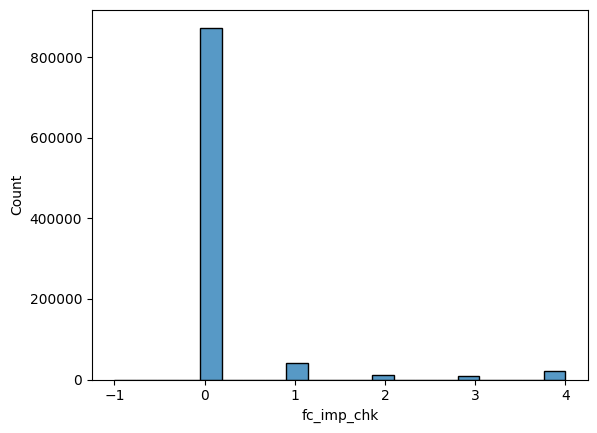

In [12]:
# Distribution of impressions
sns.histplot(data_x['fc_imp_chk'])
plt.show()

**Vast majority of the data has only 1 impression**

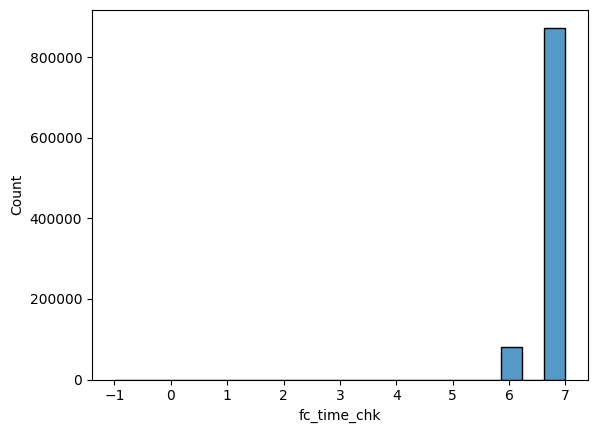

In [13]:
# Distribution of time passed
sns.histplot(data_x['fc_time_chk'])
plt.show()


**As we see, most ads wew shown for the first time**

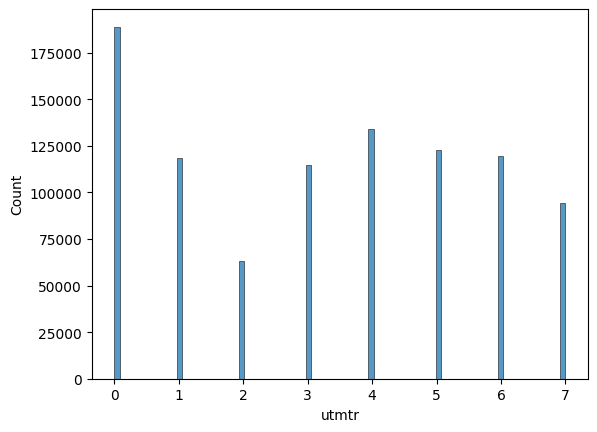

In [14]:
# Distribution of time periods
sns.histplot(data_x['utmtr'])
plt.show()

**Lowes number of adds were shown from 06-09 and the highest number of adds is shown from 00 to 03. During other periods number of ads are almost equal**

In [15]:
# First 20 region with maximum number of ads
data_x['mm_dma'].value_counts()[:20]

mm_dma
501    153866
524     96101
517     55163
0       46174
505     43398
609     28468
511     27655
659     24960
510     24267
504     19483
544     18975
518     18429
630     17689
561     16542
535     16358
602     15643
527     14788
640     13399
515     13243
560     12694
Name: count, dtype: int64

In [16]:
# Repeating ids
data_x['uid'].duplicated().sum()

237

In [17]:
# How many repeating ids are differ only with time?
data_x.iloc[:, 1:].duplicated().sum()

236

So, 236 repeating id are differ only by time. We will take the latest appearance

In [18]:
# One left repeating id
miss_id = set(data_x[data_x['uid'].duplicated()]['uid']) -  set(data_x.iloc[:, 1:][data_x.iloc[:, 1:].duplicated()]['uid'])
data_x[data_x['uid'] == list(miss_id)[0]]

,reg_time,uid,fc_imp_chk,fc_time_chk,utmtr,mm_dma,osName,model,hardware,site_id
221,2021-07-21 19:37:37,00000000-0000-0001-6268-962454071260,0,7,6,501,Unknown os,Unknow model,Unknown hardwere,www.ninersnation.com
245,2021-07-21 19:39:07,00000000-0000-0001-6268-962454071260,0,7,6,501,Android,SM-A025U,Mobile Phone,www.ninersnation.com


In [19]:
# Removing one with unnown device and alos other duplicates
data_x = data_x.drop(221).sort_values(by='reg_time').drop_duplicates(subset='uid', keep='first').reset_index(drop = True)

### Investiagating x data

In [20]:
data_y.head()

,uid,tag
0,00000000-0000-0001-6268-860993461181,fclick
1,00000000-0000-0001-6268-861002231327,fclick
2,00000000-0000-0001-6268-861081671348,fclick
3,00000000-0000-0001-6268-869788991321,fclick
4,00000000-0000-0001-6268-869788451455,fclick


In [21]:
# If there nans?
data_y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15359 entries, 0 to 15358
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   uid     15359 non-null  object
 1   tag     15359 non-null  object
dtypes: object(2)
memory usage: 240.1+ KB


In [22]:
# available actions
data_y['tag'].unique()

array(['fclick', 'vregistration', 'registration', 'vcontent', 'vsignup',
       'vmisc', 'vlead', 'signup', 'misc', 'lead', 'content'],
      dtype=object)

In [23]:
# number of duplicates
data_y.duplicated().sum()

2882

In [24]:
# Let's remove this dupicates, as it is not possible to identify wheter it is data issue or program issue or it really shod be duplicated
data_y.drop_duplicates(inplace=True)

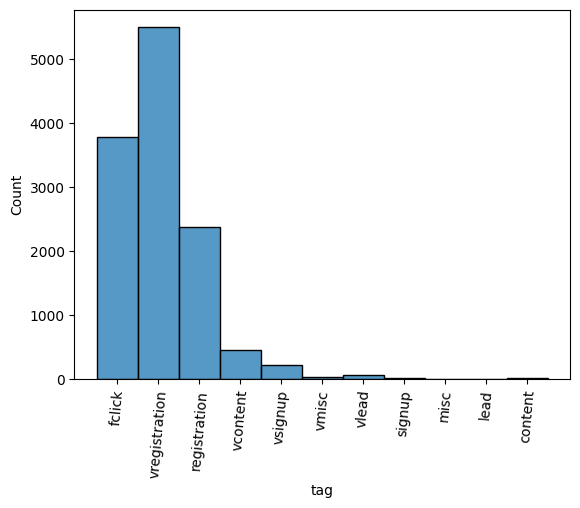

In [25]:
# Distribution of actions
sns.histplot(data_y['tag'])
plt.xticks(rotation = 85)
plt.show()

**we can see that 3 most common actions are clic for the first time, registration and click on registration**

In [26]:
# merging data
data = data_x.merge(data_y, how='inner')

In [27]:
# Defining clicks
data['clicks'] = data['tag'].apply(lambda x: 0 if x.startswith('v') else 1)

In [28]:
data

,reg_time,uid,fc_imp_chk,fc_time_chk,utmtr,mm_dma,osName,model,hardware,site_id,tag,clicks
0,2021-07-21 19:29:20,00000000-0000-0001-6268-957597321099,0,7,6,517,Android,SM-N960U,Mobile Phone,dotesports.com,vcontent,0
1,2021-07-21 19:29:54,00000000-0000-0001-6268-957946481763,0,7,6,505,Android,Pixel 4a,Mobile Phone,online.seterra.com,vregistration,0
2,2021-07-21 19:30:05,00000000-0000-0001-6268-958052831367,0,7,6,501,iOS,iPhone,Mobile Phone,hiphopdx.com,vregistration,0
3,2021-07-21 19:30:15,00000000-0000-0001-6268-958153731939,0,7,6,517,Android,SM-G991U,Mobile Phone,www.vivaelbirdos.com,vregistration,0
4,2021-07-21 19:32:05,00000000-0000-0001-6268-959263331420,0,7,6,517,Android,SM-N975U,Mobile Phone,www.landgrantholyland.com,vregistration,0
...,...,...,...,...,...,...,...,...,...,...,...,...
12376,2021-08-06 15:18:15,00000000-0000-0001-6282-630943861926,0,7,5,556,iOS,iPhone,Mobile Phone,www.digitalspy.com,fclick,1
12377,2021-08-06 15:18:15,00000000-0000-0001-6282-630943861926,0,7,5,556,iOS,iPhone,Mobile Phone,www.digitalspy.com,registration,1
12378,2021-08-06 15:27:50,00000000-0000-0001-6282-636710091771,1,6,5,0,Android,SM-G975U,Mobile Phone,www.digitalspy.com,fclick,1
12379,2021-08-06 16:05:52,00000000-0000-0001-6282-626705991151,3,6,5,567,iOS,iPhone,Mobile Phone,whatculture.com,vregistration,0


In [29]:
# grouping based on impressions
impression_clics = data.groupby('fc_imp_chk')['clicks'].sum().reset_index()

Text(30.764506172839504, 0.5, 'Number of clicks')

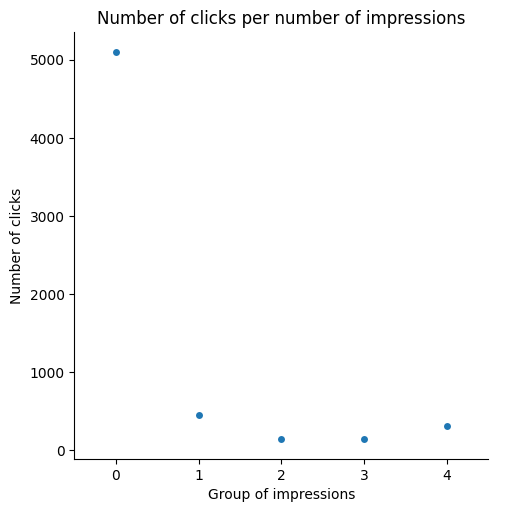

In [30]:
# Number of clicks based on number of impressions
sns.catplot(x = 'fc_imp_chk', y = 'clicks', data = impression_clics)
plt.title('Number of clicks per number of impressions')
plt.xlabel('Group of impressions')
plt.ylabel('Number of clicks')

We can see, that ads with only one impressions have the highest number of clicks, further impressions not so effective. It may indicate, that one not interested in ad, next impressions will not add interest, so the probability that after first impression the ad will be clicked

In [31]:
time_clicks = data.groupby('fc_time_chk')['clicks'].sum().reset_index()

Text(30.764506172839504, 0.5, 'Number of clicks')

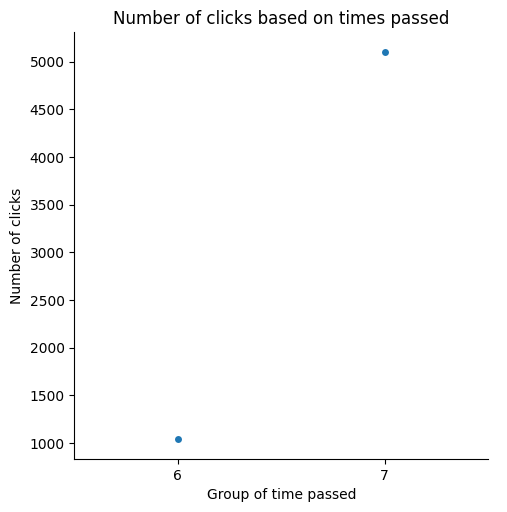

In [32]:
# Number of clicks based on time ad was shown
sns.catplot(x = 'fc_time_chk', y = 'clicks', data = time_clicks)
plt.title('Number of clicks based on times passed')
plt.xlabel('Group of time passed')
plt.ylabel('Number of clicks')

Here it can also be seen, that ads which where shown for ther first time (never shown before) were clicked more. So, again, next impressions don't play much role

In [33]:
utmtr_clicks = data.groupby('utmtr')['clicks'].sum().reset_index()

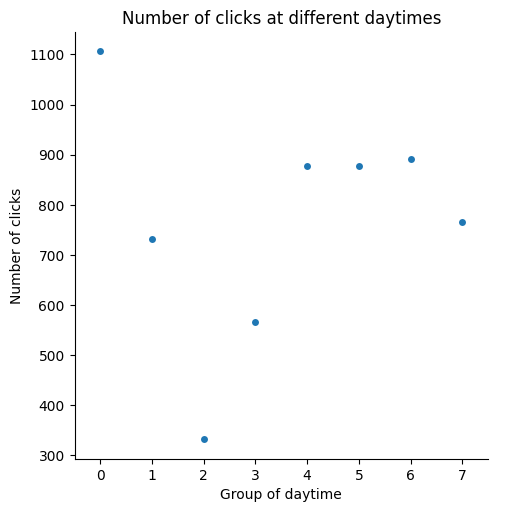

In [34]:
# Number of clicks based on time ad was shown
sns.catplot(x = 'utmtr', y = 'clicks', data = utmtr_clicks)
plt.title('Number of clicks at different daytimes')
plt.xlabel('Group of daytime')
plt.ylabel('Number of clicks')
plt.show()

We can notice, that the most clicks were made from 00-03, and the lowest number of clicks were 06-09 and 09-12

In [35]:
mm_dma_clicks = data.groupby('mm_dma')['clicks'].sum().reset_index()
mm_dma_clicks_20 = mm_dma_clicks.sort_values(by='clicks', ascending = False)[:20]

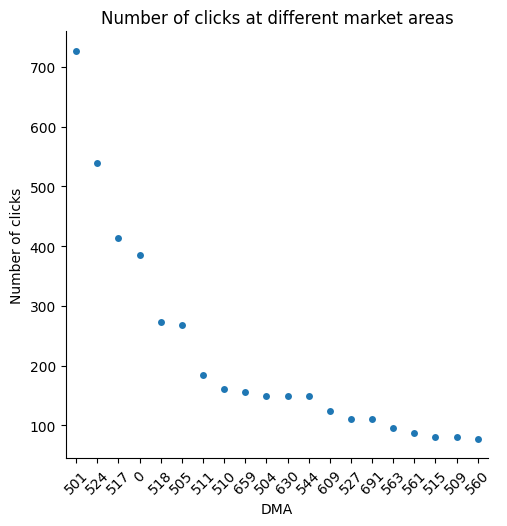

In [36]:
# Number of clicks by market area
sns.catplot(x='mm_dma', y='clicks', data=mm_dma_clicks_20, order=mm_dma_clicks_20['mm_dma'])
plt.title('Number of clicks at different market areas')
plt.xlabel('DMA')
plt.ylabel('Number of clicks')
plt.xticks(rotation = 45)
plt.show()

Here are 20 most clicked areas. The higest number of clics was in area 501, then in 524, 517 and 0. It's better to have more informaion about these groups so we can somehow group them to make this feature useful in modeling

In [37]:
os_clicks = data.groupby('osName')['clicks'].sum().reset_index()

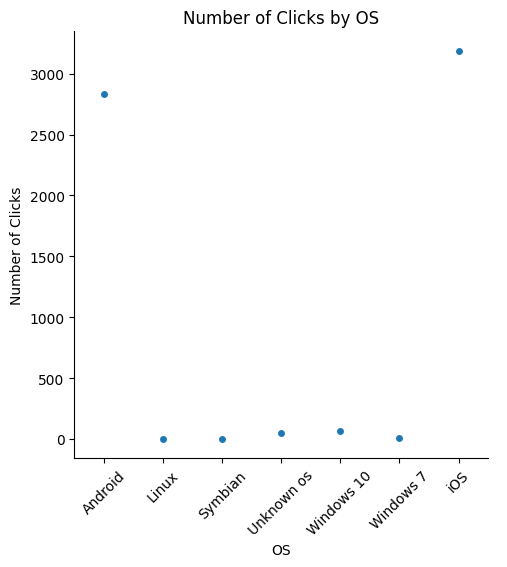

In [38]:
# Number of clicks based on time ad was shown
sns.catplot(x = 'osName', y = 'clicks', data = os_clicks)
plt.title('Number of Clicks by OS')
plt.xlabel('OS')
plt.ylabel('Number of Clicks')
plt.xticks(rotation = 45)
plt.show()

In most cases ads were clicked on Android and on iOS, that is on phones

In [39]:
hardware_clicks = data.groupby('hardware')['clicks'].sum().reset_index()

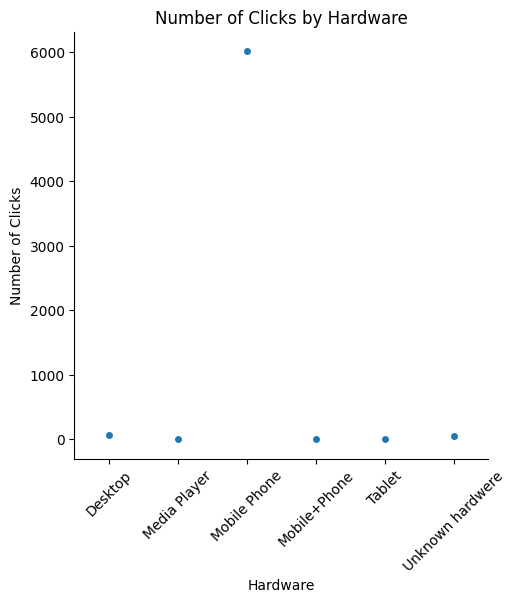

In [40]:
# Number of clicks based on time ad was shown
sns.catplot(x = 'hardware', y = 'clicks', data = hardware_clicks)
plt.title('Number of Clicks by Hardware')
plt.xlabel('Hardware')
plt.ylabel('Number of Clicks')
plt.xticks(rotation = 45)
plt.show()

So as in above, it is obvious that ads are more effective on phones (in applications)

In [41]:
site_clicks = data.groupby('site_id')['clicks'].sum().reset_index()
site_clicks_20 = site_clicks[:20]

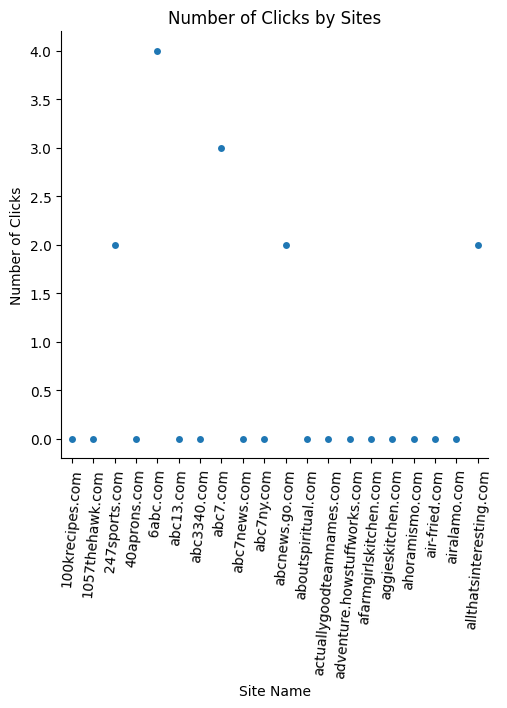

In [42]:
# Number of clicks based on time ad was shown
sns.catplot(x = 'site_id', y = 'clicks', data = site_clicks_20)
plt.title('Number of Clicks by Sites')
plt.xlabel('Site Name')
plt.ylabel('Number of Clicks')
plt.xticks(rotation = 85)
plt.show()

Most clicks were 6abc.com, also there were many clicks on 274sports.com, abc7.com, abcnews.com and allthatsinteresting.com sites. We need more information about this pages so we can group them and use in model

### Importance of features

As our variables are all categorical, we need to use correlation measurement for categorical features.
We are going to use Chi-Square Test for that

In [43]:
from scipy.stats import chi2_contingency
datasets = [impression_clics, time_clicks, utmtr_clicks, os_clicks, hardware_clicks, mm_dma_clicks, site_clicks]
# Assuming data is your DataFrame with categorical variables
for var in datasets:        
    contingency_table = pd.crosstab(var.iloc[:,0], var['clicks'])
    chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
    print(f"Chi-square Test for {var.columns[0]} and clicks:")
    print("Chi-square Statistic:", chi2_stat)
    print("P-value:", p_value)
    print("\n")


Chi-square Test for fc_imp_chk and clicks:
Chi-square Statistic: 20.000000000000004
P-value: 0.2202206466016988


Chi-square Test for fc_time_chk and clicks:
Chi-square Statistic: 0.0
P-value: 1.0


Chi-square Test for utmtr and clicks:
Chi-square Statistic: 56.0
P-value: 0.2288519727170065


Chi-square Test for osName and clicks:
Chi-square Statistic: 35.0
P-value: 0.242640437349738


Chi-square Test for hardware and clicks:
Chi-square Statistic: 24.00000000000001
P-value: 0.24239216167051206


Chi-square Test for mm_dma and clicks:
Chi-square Statistic: 6607.999999999999
P-value: 0.3107828797756828


Chi-square Test for site_id and clicks:
Chi-square Statistic: 54538.0
P-value: 0.4545941109531344




**We can see that all the p-values are greater the 0.05, so there is no strong correlation between number of clicks and any of our features  
 Relativly important features, based on p-value, are fc_imp_chk and utmtr**

#### Factor importances using Random Forest model

In [44]:
X = data[['fc_imp_chk', 'fc_time_chk', 'utmtr', 'osName', 'hardware']]
y = data['clicks']

In [45]:
X = pd.get_dummies(X, columns=X.columns).astype(int)

In [46]:
train_x, test_x, train_y, test_y = train_test_split(X, y, random_state=42, stratify=y)

In [47]:
rf = RandomForestClassifier(max_depth=10, n_estimators = 5000, max_leaf_nodes = 50, min_samples_leaf = 20)

In [48]:
rf.fit(train_x, train_y)

RandomForestClassifier(max_depth=10, max_leaf_nodes=50, min_samples_leaf=20,
                       n_estimators=5000)

In [49]:
y_pred = rf.predict(test_x)

In [50]:
sorted(list(zip(rf.feature_names_in_, rf.feature_importances_)), key=lambda x: x[1], reverse=True)

[('fc_imp_chk_0', 0.17579707459696695),
 ('fc_time_chk_6', 0.1736721211488234),
 ('fc_time_chk_7', 0.16727965187955396),
 ('osName_iOS', 0.13093315869983418),
 ('osName_Android', 0.11255773741089353),
 ('utmtr_3', 0.047591815095475554),
 ('fc_imp_chk_4', 0.04279403960247648),
 ('fc_imp_chk_1', 0.04149501697706949),
 ('utmtr_4', 0.018936845569641602),
 ('utmtr_1', 0.015762809162915024),
 ('hardware_Desktop', 0.012171594318457055),
 ('utmtr_6', 0.010658163478691182),
 ('osName_Windows 10', 0.008468057996199912),
 ('fc_imp_chk_3', 0.007868829241982565),
 ('utmtr_7', 0.007803159400019424),
 ('fc_imp_chk_2', 0.0077389873253455145),
 ('hardware_Mobile Phone', 0.006193694140154483),
 ('utmtr_0', 0.004183657527127484),
 ('utmtr_5', 0.0035766714820354476),
 ('utmtr_2', 0.0023483923168716673),
 ('hardware_Unknown hardwere', 0.001095322696531542),
 ('osName_Unknown os', 0.0010731999329337365),
 ('osName_Linux', 0.0),
 ('osName_Symbian', 0.0),
 ('osName_Windows 7', 0.0),
 ('hardware_Media Player',

**As we see, more important factors are whether ad was shown before or not, if it was shown more than a day before, if it was shown on phone**

### Solving the same task with LLM

In [51]:
config = configparser.ConfigParser()
config.read('config.ini')
password = config.get('Openai', 'password')

In [53]:
con = ' '.join(X.columns) + '\n' + '\n'.join([' '.join(i) for i in X.astype(str).values])

In [64]:
client = OpenAI(api_key = password)

completion = client.chat.completions.create(
  model="gpt-3.5-turbo",
  messages=[
    {"role": "system", "content": con},
    {"role": "user", "content": "Given a dataset of online ad impressions and events. Inidentify the factors that strongly correlate with ad clicks."}
  ]
)

model_response = response['choices'][0]['text']
print(model_response)

RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

**Due to openai limitation, I couldn't use openai's models**

While using HuggingFase transformers, it was abvious that there were limitation of imput tokens, wheres our data had more thrn 140 000 rows.
My suggestion is to ask model to write python code that will find most important factors

In [68]:
tokenizer = AutoTokenizer.from_pretrained("stabilityai/stable-code-3b", trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
  "stabilityai/stable-code-3b",
  trust_remote_code=True,
  torch_dtype="auto",
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [69]:
prompt = """I have X data, it hase 140 000 rows, first row look like this:
'fc_imp_chk_0 fc_imp_chk_1 fc_imp_chk_2 fc_imp_chk_3 fc_imp_chk_4 fc_time_chk_6 fc_time_chk_7 utmtr_0 utmtr_1 utmtr_2 utmtr_3 utmtr_4 utmtr_5 utmtr_6 utmtr_7 osName_Android osName_Linux osName_Symbian osName_Unknown os osName_Windows 10 osName_Windows 7 osName_iOS hardware_Desktop hardware_Media Player hardware_Mobile Phone hardware_Mobile+Phone hardware_Tablet hardware_Unknown hardwere\n1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0\n1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 ...
...
and y data of clics
clicks: 0, 0 ...
write a python code, to read this data, and Inidentify the factors that strongly correlate with ad clicks
inputs = tokenizer(prompt, return_tensors="pt")
"""

In [75]:
model
inputs = tokenizer(prompt, return_tensors="pt")
tokens = model.generate(
  **inputs,
  max_new_tokens=60,
  temperature=0.1,
  do_sample=True,
)
print(tokenizer.decode(tokens[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


I have X data, it hase 140 000 rows, first row look like this:
'fc_imp_chk_0 fc_imp_chk_1 fc_imp_chk_2 fc_imp_chk_3 fc_imp_chk_4 fc_time_chk_6 fc_time_chk_7 utmtr_0 utmtr_1 utmtr_2 utmtr_3 utmtr_4 utmtr_5 utmtr_6 utmtr_7 osName_Android osName_Linux osName_Symbian osName_Unknown os osName_Windows 10 osName_Windows 7 osName_iOS hardware_Desktop hardware_Media Player hardware_Mobile Phone hardware_Mobile+Phone hardware_Tablet hardware_Unknown hardwere
1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0
1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0...
...
and y data of clics
clicks: 0, 0...
write a python code, to read this data, and Inidentify the factors that strongly correlate with ad clicks
inputs = tokenizer(prompt, return_tensors="pt")
outputs = model.forward(inputs.input_ids, attention_mask=inputs.attention_mask)
logits = outputs.logits
predicted_class_idx = torch.argmax(logits).item()
print("Predicted class:", model.config.id


**The model didn't provide the complete code so it is required further tuning, or looking for another pretrained model**